In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data'
columns = [f'A{i}' for i in range(1, 17)]
df = pd.read_csv(url, header=None, names=columns)

# Clean data
df.replace('?', np.nan, inplace=True)
df['A16'] = df['A16'].map({'+': 1, '-': 0})
df.dropna(subset=['A16'], inplace=True)

X = df.drop('A16', axis=1)
y = df['A16'].astype(int)

# Encode categorical
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include='object'):
    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col].astype(str))

X_encoded = X_encoded.apply(pd.to_numeric)
X_encoded.fillna(X_encoded.mean(), inplace=True)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)


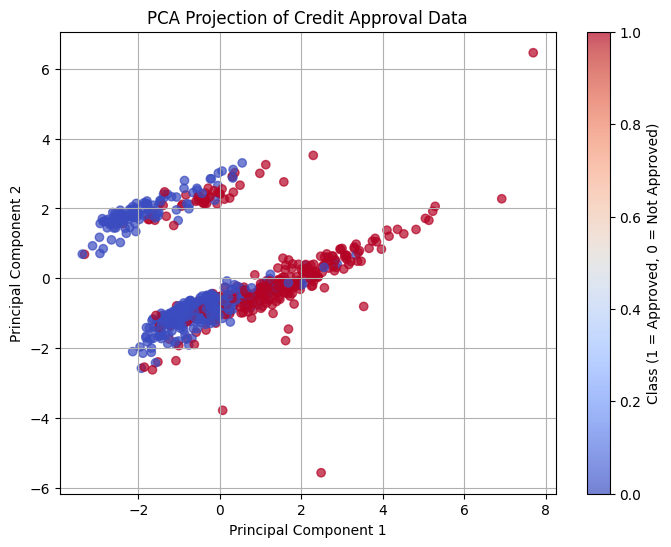

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot PCA projection
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.title('PCA Projection of Credit Approval Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Class (1 = Approved, 0 = Not Approved)')
plt.grid(True)
plt.show()



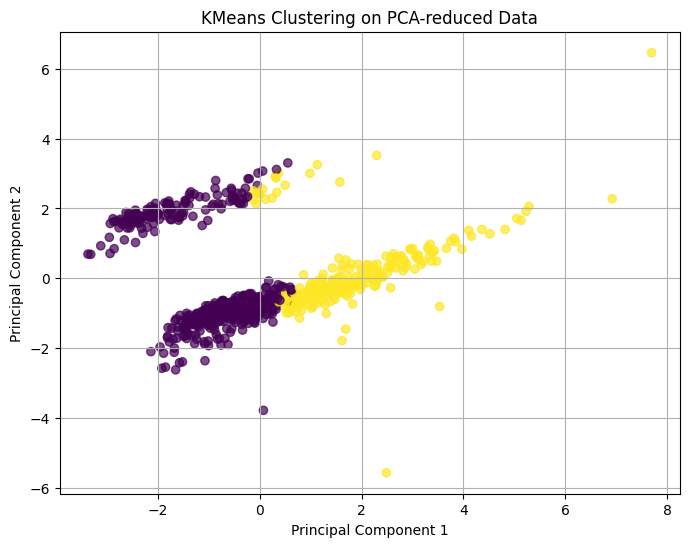

🟢 Silhouette Score (KMeans): 0.14165639006083558


In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Plot KMeans clusters
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.title('KMeans Clustering on PCA-reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Calculate silhouette score
sil_score = silhouette_score(X_scaled, clusters)
print("🟢 Silhouette Score (KMeans):", sil_score)


k=2, Silhouette Score=0.163
k=3, Silhouette Score=0.157
k=4, Silhouette Score=0.161
k=5, Silhouette Score=0.140
k=6, Silhouette Score=0.123
k=7, Silhouette Score=0.124
k=8, Silhouette Score=0.127
k=9, Silhouette Score=0.123


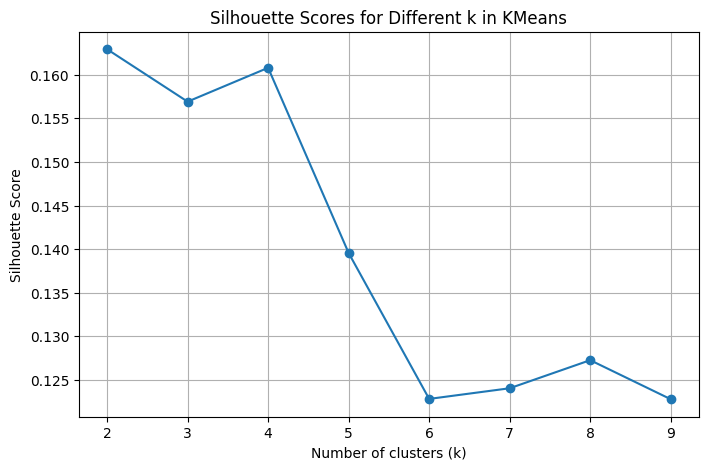

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

sil_scores = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    clusters = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, clusters)
    sil_scores.append(score)
    print(f'k={k}, Silhouette Score={score:.3f}')

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(k_values, sil_scores, marker='o')
plt.title('Silhouette Scores for Different k in KMeans')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


k=2, Agglomerative Silhouette Score=0.144
k=3, Agglomerative Silhouette Score=0.145
k=4, Agglomerative Silhouette Score=0.150
k=5, Agglomerative Silhouette Score=0.155
k=6, Agglomerative Silhouette Score=0.131
k=7, Agglomerative Silhouette Score=0.108
k=8, Agglomerative Silhouette Score=0.111
k=9, Agglomerative Silhouette Score=0.112


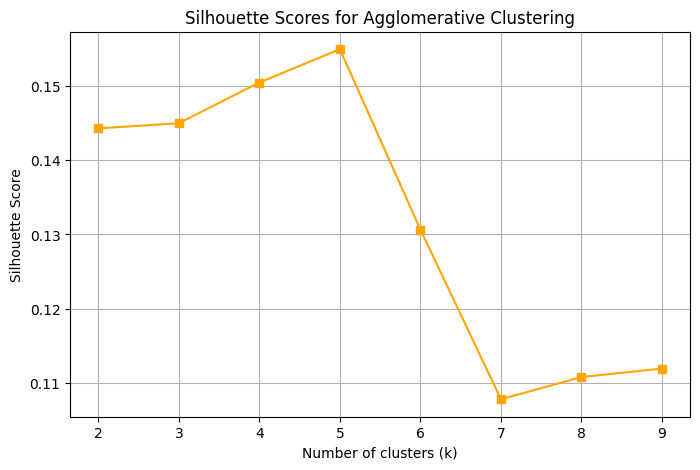

In [9]:
from sklearn.cluster import AgglomerativeClustering

agg_scores = []
for k in k_values:
    agg = AgglomerativeClustering(n_clusters=k)
    clusters = agg.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, clusters)
    agg_scores.append(score)
    print(f'k={k}, Agglomerative Silhouette Score={score:.3f}')

# Plot Agglomerative scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, agg_scores, marker='s', color='orange')
plt.title('Silhouette Scores for Agglomerative Clustering')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


Close to +1: Well-clustered points, clearly separated from other clusters.

Close to 0: Points are on or near the decision boundary between clusters.

Negative values: Points may be assigned to the wrong cluster.

A score around 0.14 is quite low, indicating that the clusters formed by KMeans are poorly separated or overlapping. This suggests:

The natural groupings in the data might not be very strong or clear.

The clusters might be mixing data points from different classes.

KMeans clustering may not be the best tool to discover meaningful clusters in this dataset as-is. We might improve this by trying other clustering methods, adjusting cluster numbers, or refining features.

In [10]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

dbscan = DBSCAN(eps=1.5, min_samples=5)  # Tune eps & min_samples!
clusters = dbscan.fit_predict(X_scaled)

# Ignore noise (-1 label) points for silhouette score calculation
mask = clusters != -1
if len(set(clusters[mask])) > 1:  # Need at least 2 clusters
    score = silhouette_score(X_scaled[mask], clusters[mask])
    print(f'DBSCAN Silhouette Score (excluding noise): {score:.3f}')
else:
    print("DBSCAN found less than 2 clusters, silhouette score not applicable.")


DBSCAN Silhouette Score (excluding noise): 0.301


In [11]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.1)  # Remove features with low variance
X_reduced = selector.fit_transform(X_scaled)

print(f'Original features: {X_scaled.shape[1]}, After selection: {X_reduced.shape[1]}')

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_reduced)
score = silhouette_score(X_reduced, clusters)
print(f'Silhouette Score after feature selection: {score:.3f}')


Original features: 15, After selection: 15
Silhouette Score after feature selection: 0.142


In [12]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05, random_state=42)
outliers = iso.fit_predict(X_scaled)

# Keep only inliers
X_inliers = X_scaled[outliers == 1]

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_inliers)
score = silhouette_score(X_inliers, clusters)
print(f'Silhouette Score after outlier removal: {score:.3f}')


Silhouette Score after outlier removal: 0.130


🔵 SVM Mean Accuracy (5-fold CV): 0.8478260869565217
🔹 Individual Fold Scores: [0.62318841 0.94927536 0.96376812 0.77536232 0.92753623]


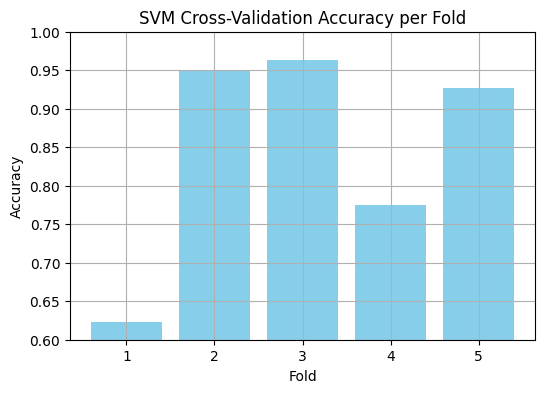

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Train SVM with 5-fold cross-validation
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
cv_scores = cross_val_score(svm_model, X_scaled, y, cv=5)

# Print results
print("🔵 SVM Mean Accuracy (5-fold CV):", np.mean(cv_scores))
print("🔹 Individual Fold Scores:", cv_scores)

# Plot fold scores
plt.figure(figsize=(6,4))
plt.bar(range(1, 6), cv_scores, color='skyblue')
plt.title("SVM Cross-Validation Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.ylim(0.6, 1.0)
plt.grid(True)
plt.show()



This means the SVM model correctly predicts the credit approval decision about 85% of the time on average. This is a strong performance, especially given the complexity of real-world credit data.



The SVM is a good model choice for this dataset and captures relevant patterns for classification effectively.
